In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!cp "/content/drive/MyDrive/Colab Notebooks/data/img_align_celeba.zip" "."
!unzip "./img_align_celeba.zip" -d "./GAN/"


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: ./GAN/img_align_celeba/197600.jpg  
 extracting: ./GAN/img_align_celeba/197601.jpg  
 extracting: ./GAN/img_align_celeba/197602.jpg  
 extracting: ./GAN/img_align_celeba/197603.jpg  
 extracting: ./GAN/img_align_celeba/197604.jpg  
 extracting: ./GAN/img_align_celeba/197605.jpg  
 extracting: ./GAN/img_align_celeba/197606.jpg  
 extracting: ./GAN/img_align_celeba/197607.jpg  
 extracting: ./GAN/img_align_celeba/197608.jpg  
 extracting: ./GAN/img_align_celeba/197609.jpg  
 extracting: ./GAN/img_align_celeba/197610.jpg  
 extracting: ./GAN/img_align_celeba/197611.jpg  
 extracting: ./GAN/img_align_celeba/197612.jpg  
 extracting: ./GAN/img_align_celeba/197613.jpg  
 extracting: ./GAN/img_align_celeba/197614.jpg  
 extracting: ./GAN/img_align_celeba/197615.jpg  
 extracting: ./GAN/img_align_celeba/197616.jpg  
 extracting: ./GAN/img_align_celeba/197617.jpg  
 extracting: ./GAN/img_align_celeba/197618.jpg  
 extracting: ./GAN/img_align_cele

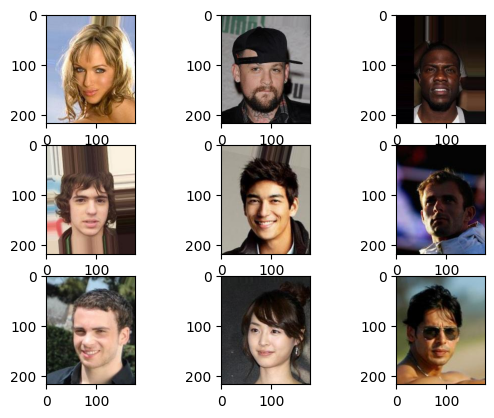

In [7]:
import glob
import matplotlib.pyplot as plt
import os

from PIL import Image

# 이미지까지의 경로
pth_to_imgs = "./GAN/img_align_celeba"
imgs = glob.glob(os.path.join(pth_to_imgs, "*"))

# 9개의 이미지를 보여줌
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = Image.open(imgs[i])
    plt.imshow(img)

plt.show()


In [8]:
import torch
import torchvision.transforms as tf

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

# 이미지의 전처리 과정
transforms = tf.Compose([
    tf.Resize(64),
    tf.CenterCrop(64),
    tf.ToTensor(),
    tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ImageFolder()를 이용해 데이터셋을 작성
# root는 최상위 경로를, transform은 전처리를 뜻함
dataset = ImageFolder(
    root="./GAN",
    transform=transforms
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)


In [9]:
# Generator 정의
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 생성자를 구성하는 층 정의
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


In [10]:
# Discriminator 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 감별자를 구성하는 층 정의
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)


In [12]:
def weights_init(m):
    # 층의 종류 추출
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # 합성곱층 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # 배치정규화층 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 생성자 정의
G = Generator().to(device)
# 생성자 가중치 초기화
G.apply(weights_init)

# 감별자 정의
D = Discriminator().to(device)
# 감별자 가중치 초기화
D.apply(weights_init)

import tqdm

from torch.optim.adam import Adam

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))


In [14]:
for epochs in range(1):
    iterator = tqdm.tqdm(enumerate(loader, 0), total=len(loader))

    for i, data in iterator:
        D_optim.zero_grad()

        # 실제 이미지에는 1, 생성된 이미지에는 0으로 정답 설정
        label = torch.ones_like(data[1], dtype=torch.float32).to(device)
        label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)

        # 실제 이미지를 감별자에 입력
        real = D(data[0].to(device))

        # 실제 이미지에 대한 감별자의 오차 계산
        Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
        Dloss_real.backward()

        # 가짜 이미지 생성
        noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
        fake = G(noise)

        # 가짜 이미지를 감별자에 입력
        output = D(fake.detach())

        # 가짜 이미지에 대한 감별자의 오차 계산
        Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
        Dloss_fake.backward()

        # 감별자의 전체 오차를 학습
        Dloss = Dloss_real + Dloss_fake
        D_optim.step()

        # 생성자의 학습
        G_optim.zero_grad()
        output = D(fake)
        Gloss = nn.BCELoss()(torch.squeeze(output), label)
        Gloss.backward()
        G_optim.step()

        iterator.set_description(f"epoch:{epochs} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}")

torch.save(G.state_dict(), "Generator.pth")
torch.save(D.state_dict(), "Discriminator.pth")


epoch:0 iteration:1582 D_loss:0.0006650082068517804 G_loss:8.48176097869873: 100%|██████████| 1583/1583 [07:56<00:00,  3.32it/s]


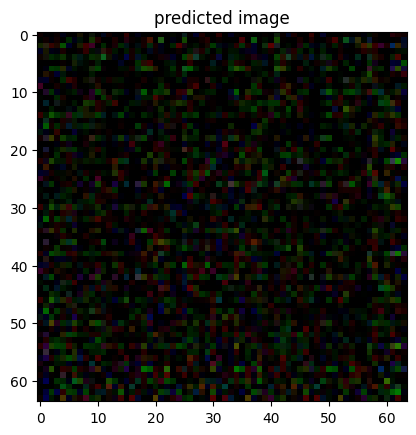

In [15]:
with torch.no_grad():
    G.load_state_dict(
        torch.load("./Generator.pth", map_location=device)
    )

    # 특징 공간 상의 랜덤한 하나의 점을 지정
    feature_vector = torch.randn(1, 100, 1, 1).to(device)

    # 이미지 생성
    pred = G(feature_vector).squeeze()
    pred = pred.permute(1, 2, 0).cpu().numpy()

plt.imshow(pred)
plt.title("predicted image")
plt.show()
